In [1]:
# 모듈 임포트
import os
import torch
from PIL import Image
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# 경로 설정
%cd ../Covid19-dataset/

c:\Users\User\Desktop\보경\졸업논문(생체의공)\Covid19-dataset


Dataloader 구현

In [3]:
# Custom Dataset 구현
class CustomDataset(Dataset):
    def readData(self):
        all_images = []
        all_labels = []
        
        class_names = os.walk(self.dataset_path).__next__()[1]
        
        for idx,class_name in enumerate(class_names):
            img_dir = os.path.join(self.dataset_path,class_name)
            img_names = os.walk(img_dir).__next__()[2]
            print('class name: {}, label: {}, num_images: {}'.format(class_name, idx, len(img_names)))
            
            for img_file in img_names:
                img_path = os.path.join(img_dir,img_file)
                image = Image.open(img_path)
                if image is not None:
                    all_images.append(img_path)
                    all_labels.append(idx)
                    
        return all_images, all_labels, len(all_images), len(class_names)
        
    def __init__(self, dataset_path, transforms=transforms.Resize((256,256))):
        self.dataset_path = dataset_path
        self.transforms = transforms
        self.images, self.labels, self.num_images, self.num_classes = self.readData()
        
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        image = Image.open(image)
        image = image.convert('L') # gray scale
        
        if self.transforms is not None:
            image = self.transforms(image)
        
        return {'image':image, 'label':label}
    
    def __len__(self):
        return self.num_images
        

데이터 시각화

check test dataset...
class name: Covid, label: 0, num_images: 26
class name: Normal, label: 1, num_images: 20
class name: Viral Pneumonia, label: 2, num_images: 20
test size: 66


check total dataset(train + val)...
class name: Covid, label: 0, num_images: 111
class name: Normal, label: 1, num_images: 70
class name: Viral Pneumonia, label: 2, num_images: 70


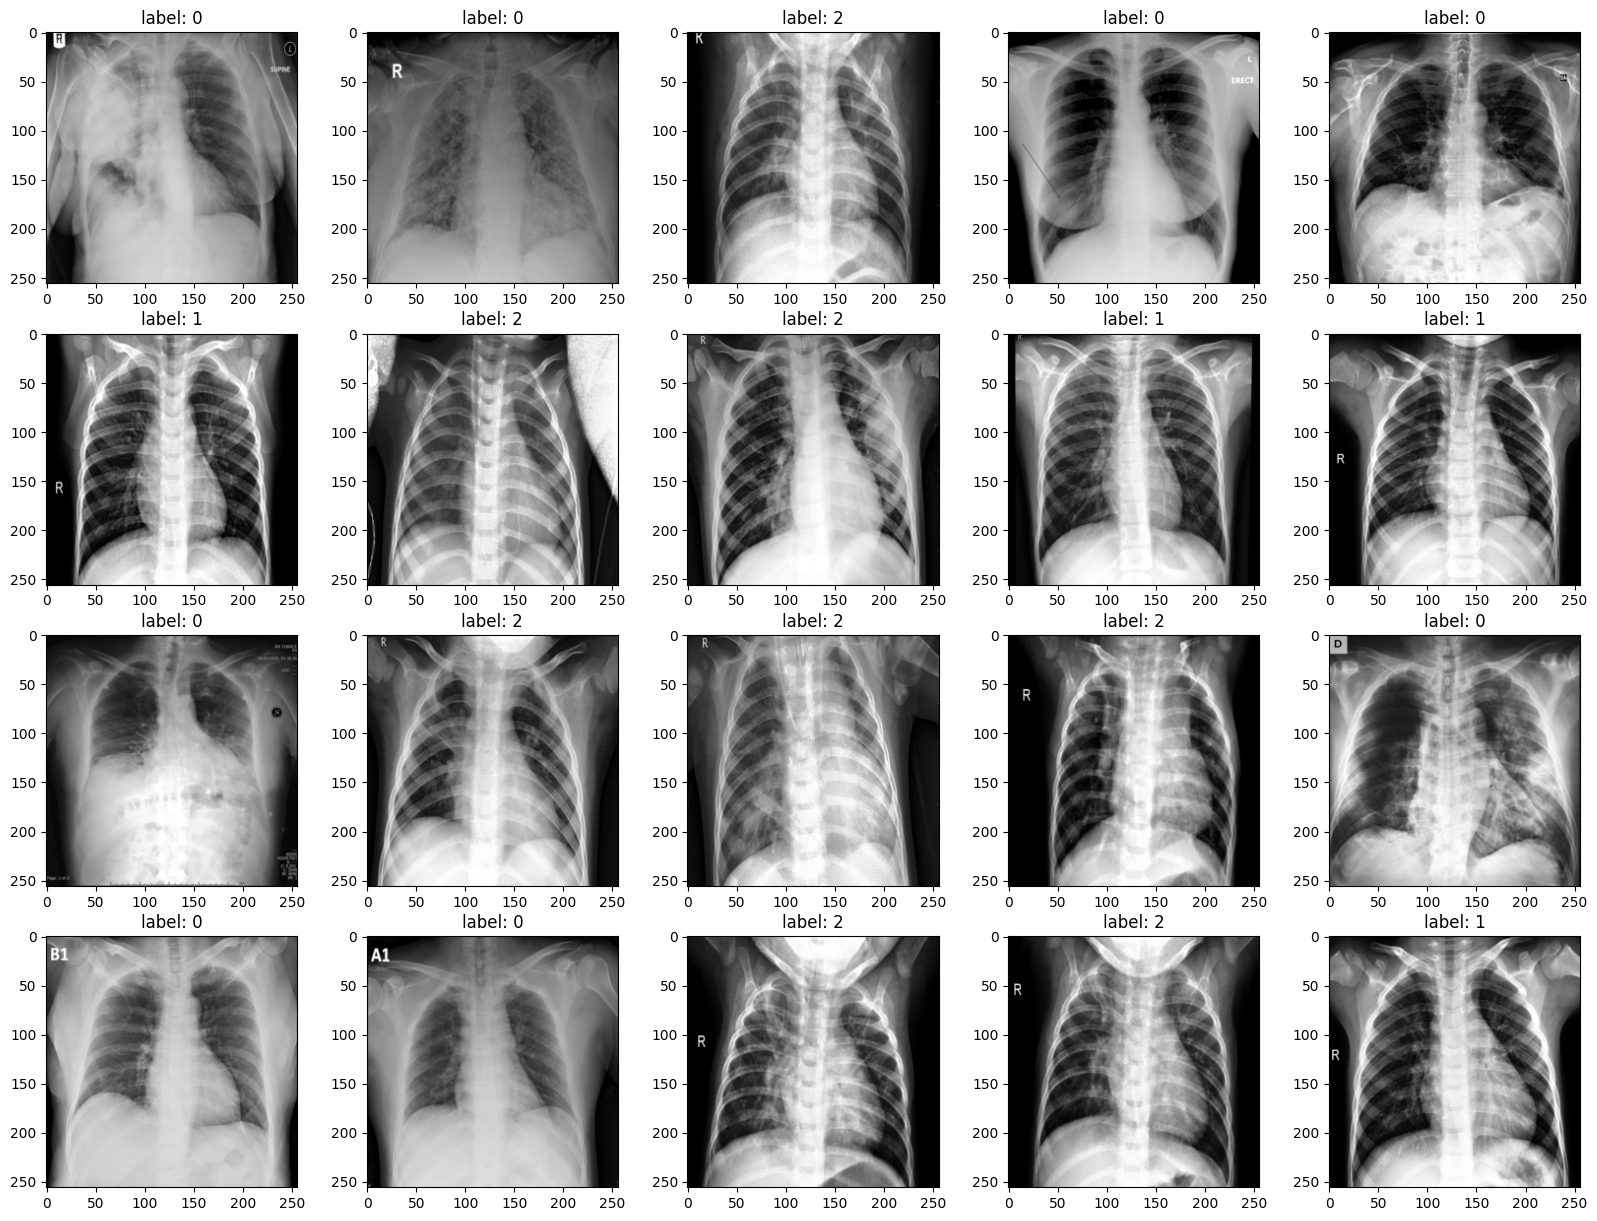

In [5]:
# 데이터 시각화
print('check test dataset...')
test_transforms = transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor()])
test_dataset = CustomDataset('./test',test_transforms)
print('test size: {}'.format(test_dataset.num_images))
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=True)

plt.figure(figsize=(20,15))
to_image = transforms.ToPILImage()
for item in test_loader:
    images = item['image']
    labels = item['label']
    
    for idx, img in enumerate(images):
        img = to_image(img)
        plt.subplot(4,5,idx+1)
        plt.title('label: {}'.format(labels[idx]))
        plt.imshow(img,cmap='gray')
    
    break


print('\n')
print('check total dataset(train + val)...')
train_transforms=transforms.Compose([transforms.Resize((256,256)),transforms.RandomCrop(224),transforms.RandomHorizontalFlip(),transforms.ToTensor()])
total_dataset = CustomDataset('./train', train_transforms)


In [6]:
# 데이터셋 분할
train_size=int(total_dataset.num_images*0.9)
val_size=total_dataset.num_images-train_size

print('train size: {}, val size: {}'.format(train_size, val_size))

train_dataset, val_dataset=random_split(total_dataset,[train_size, val_size],generator=torch.Generator().manual_seed(42))

train size: 225, val size: 26


모델 환경 설정

In [21]:
from torchvision import models
import ssl
import torchsummary



ssl._create_default_https_context = ssl._create_unverified_context

# 모델 불러오기. ImageNet pre-trained vgg16
model=models.vgg16(pretrained=True)
model.features[0]=nn.Conv2d(1,64,kernel_size=(3,3),stride=(1,1),padding=(1,1))

num_classes=total_dataset.num_classes
avg_pooling=nn.AdaptiveAvgPool2d(output_size=(1,1))
model.avgpool = avg_pooling
vgg_classifier=nn.Sequential(
    nn.Linear(in_features=512,out_features=256,bias=True),
    nn.Dropout(p=0.5,inplace=False),
    nn.Linear(in_features=256,out_features=256,bias=True),
    nn.Dropout(p=0.5,inplace=False),
    nn.Linear(in_features=256,out_features=num_classes)
)
model.classifier=vgg_classifier
print(model)

# 하이퍼파라미터 설정
hy_batch=16
hy_epoch=100
hy_lr=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=hy_lr)

train_loader = DataLoader(train_dataset, batch_size=hy_batch, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=hy_batch, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=hy_batch, shuffle=False)


c:\Users\User\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
c:\Users\User\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

모듈 구현

In [17]:
def train_epoch(model, dataloader, optimizer):
    model.train()
    crit = nn.CrossEntropyLoss()
    sum_loss = 0

    for item in dataloader:
        images = item['image']
        labels = item['label']

        outputs = model(images)
        loss = crit(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        sum_loss += loss.item()*len(images)

    return sum_loss / len(dataloader.dataset)

def val_epoch(model, dataloader):
    model.eval()
    crit = nn.CrossEntropyLoss()
    sum_loss = 0
    correct = 0
    total = len(dataloader.dataset)

    with torch.no_grad():
        for item in dataloader:
            images = item['image']
            labels = item['label']

            outputs = model(images)
            loss = crit(outputs, labels)

            sum_loss += loss.item()*len(images)
            _, predict = torch.max(outputs.data,1)
            correct += (predict==labels).sum().item()

        accuracy = correct/total * 100

        return sum_loss/len(dataloader.dataset), accuracy
    

모델 훈련

In [22]:
PATH="../Covid19_image_classification_Kaggle/models/"
all_train_loss=[]
all_val_loss=[]
all_val_acc=[]

min_loss=np.Inf

for e in range(0,hy_epoch):
    print('epoch {}/{}...'.format(e+1,hy_epoch))
    train_loss=train_epoch(model,train_loader,optimizer)
    val_loss, val_acc=val_epoch(model,val_loader)
    print(
        '  * training loss = {:.6f}, validation loss = {:.6f}, val_acc = {:.6f}%'
        .format(train_loss, val_loss, val_acc)
    )
    all_train_loss.append(train_loss)
    all_val_loss.append(val_loss)
    all_val_acc.append(val_acc)

    if val_loss < min_loss:
        min_loss=val_loss
        print('  * best validation loss')
        torch.save(model,PATH+'model_{}.pt'.format(e+1))
        torch.save(model.state_dict(),PATH+'model_state_{}.pt'.format(e+1))
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict()
        },PATH+'min_all_{}.tar'.format(e+1))

    

epoch 1/100...
  * training loss = 1.150909, validation loss = 1.080043, val_acc = 46.153846%
  * best validation loss
epoch 2/100...


결과 시각화